# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
from lib.dataeng import Etl

In [4]:
etl = Etl()
etl.repo

'/home/benjamin/Downloads/'

In [5]:
df_weight_raw = etl._extract_poids() # extrait toutes les mesures de poids


Le fichier poids le plus récent est : data_BEN_1707727886.zip, parmi :
data_BEN_1707370614.zip
data_BEN_1706593344.zip
data_BEN_1707158534.zip
data_BEN_1707547897.zip
data_BEN_1707642115.zip
data_BEN_1707467607.zip
data_BEN_1707031718.zip
data_BEN_1706676305.zip
data_BEN_1707727886.zip
data_BEN_1706944407.zip
data_BEN_1707310570.zip
data_BEN_1707195623.zip
data_BEN_1706861557.zip
data_BEN_1706761334.zip


In [6]:
df_weight = df_weight_raw.groupby(['Date']).mean()

In [7]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-01-29,73.896667,12.780000,3.053333,58.049167,41.032500,0.172943,1690.120000
2024-01-30,73.340000,12.521538,3.037692,57.760769,40.798462,0.170732,1683.678769
2024-01-31,73.571538,12.973077,3.025385,57.560000,40.528462,0.176333,1678.926769
2024-02-01,73.963333,12.926667,3.047500,57.971667,40.935000,0.174771,1688.392000
2024-02-02,72.486000,12.187333,3.012667,57.270667,40.372667,0.168132,1672.451200
2024-02-03,72.394286,12.155000,3.011429,57.210714,40.320714,0.167899,1671.168571
2024-02-04,72.766667,12.566667,3.006667,57.177333,40.215333,0.172698,1670.320000
2024-02-05,72.806000,12.340000,3.021333,57.428667,40.501333,0.169490,1676.065600
2024-02-06,73.715333,12.574000,3.054667,58.070000,41.093333,0.170574,1690.652800


In [8]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-01-29,73.370714,12.432075,3.046224,57.878367,40.930663,0.169433,1686.274612
2024-01-30,73.470714,12.479318,3.048514,57.928001,40.971158,0.169849,1687.414151
2024-01-31,73.571767,12.574163,3.048093,57.934787,40.962248,0.170906,1687.548261
2024-02-01,73.623791,12.623925,3.047855,57.936930,40.955938,0.171459,1687.597118
2024-02-02,73.420958,12.573663,3.039783,57.791906,40.821557,0.171240,1684.301575
2024-02-03,73.284427,12.569683,3.033048,57.665783,40.696353,0.171498,1681.438473
2024-02-04,73.202642,12.587183,3.027810,57.571474,40.600448,0.171930,1679.293901
2024-02-05,73.046832,12.524326,3.023239,57.482831,40.524567,0.171436,1677.286130
2024-02-06,73.100451,12.531821,3.025664,57.527007,40.566692,0.171414,1678.282420


In [9]:
df_food_raw = etl._extract_food()  # calories par jour par repas


Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-12.zip, parmi
File-Export-2020-08-03-to-2024-02-01.zip
File-Export-2020-08-03-to-2024-02-11.zip
File-Export-2020-08-03-to-2024-02-10.zip
File-Export-2020-08-03-to-2024-02-08.zip
File-Export-2020-08-03-to-2024-02-07.zip
File-Export-2020-08-03-to-2024-02-03.zip
File-Export-2020-08-03-to-2024-01-31.zip
File-Export-2020-08-03-to-2024-02-09.zip
File-Export-2020-08-03-to-2024-02-05.zip
File-Export-2020-08-03-to-2024-02-06.zip
File-Export-2020-08-03-to-2024-02-02.zip
File-Export-2020-08-03-to-2024-02-12.zip
File-Export-2020-08-03-to-2024-01-30.zip
File-Export-2020-08-03-to-2024-02-04.zip


In [10]:
df_food = df_food_raw.groupby(['Date']).sum(numeric_only=True)

In [11]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2024-01-28,1821.9,50.7,175.7,174.7
2024-01-29,1795.7,41.3,205.5,158.7
2024-01-30,1680.9,47.8,129.8,185.4
2024-01-31,1682.0,48.1,129.8,196.3
2024-02-01,1664.6,30.4,129.2,214.4
2024-02-02,1712.0,21.4,193.8,185.3
2024-02-03,1830.5,43.9,139.5,223.6
2024-02-04,1746.8,34.6,177.3,184.5
2024-02-05,1709.9,25.7,198.4,176.7


In [12]:
df_exos_raw = etl._extract_exos()


Le fichier exercices le plus récent est : polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip, parmi :
polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1868/1868 [01:17<00:00, 24.19it/s]


In [13]:
df_exos_total = df_exos_raw.groupby(['exo_date']).sum(numeric_only=True)

In [14]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-01-28,3120.605,355.0
2024-01-29,1560.000,212.0
2024-01-30,0.000,0.0
2024-01-31,3120.000,393.0
2024-02-01,1500.000,190.0
2024-02-02,3120.000,375.0
2024-02-03,3180.000,325.0
2024-02-04,3720.000,540.0
2024-02-05,0.000,0.0


In [15]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-01-28,2271.986714,281.857143
2024-01-29,2040.439714,259.428571
2024-01-30,2040.439714,259.428571
2024-01-31,2048.927286,253.714286
2024-02-01,2074.555286,254.142857
2024-02-02,2245.883429,270.000000
2024-02-03,2228.657857,264.285714
2024-02-04,2314.285714,290.714286
2024-02-05,2091.428571,260.428571


In [16]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [17]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [18]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [19]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-01-28,73.339167,12.444167,3.043333,57.837500,40.886667,0.169678,1685.332000,1821.9,50.7,175.7,174.7,3120.605,355.0,294.128988,1979.460988,-157.560988
2024-01-29,73.896667,12.780000,3.053333,58.049167,41.032500,0.172943,1690.120000,1795.7,41.3,205.5,158.7,1560.000,212.0,181.483944,1871.603944,-75.903944
2024-01-30,73.340000,12.521538,3.037692,57.760769,40.798462,0.170732,1683.678769,1680.9,47.8,129.8,185.4,0.000,0.0,0.000000,1683.678769,-2.778769
2024-01-31,73.571538,12.973077,3.025385,57.560000,40.528462,0.176333,1678.926769,1682.0,48.1,129.8,196.3,3120.000,393.0,332.372089,2011.298858,-329.298858
2024-02-01,73.963333,12.926667,3.047500,57.971667,40.935000,0.174771,1688.392000,1664.6,30.4,129.2,214.4,1500.000,190.0,160.687639,1849.079639,-184.479639
2024-02-02,72.486000,12.187333,3.012667,57.270667,40.372667,0.168132,1672.451200,1712.0,21.4,193.8,185.3,3120.000,375.0,314.605929,1987.057129,-275.057129
2024-02-03,72.394286,12.155000,3.011429,57.210714,40.320714,0.167899,1671.168571,1830.5,43.9,139.5,223.6,3180.000,325.0,263.491712,1934.660284,-104.160284
2024-02-04,72.766667,12.566667,3.006667,57.177333,40.215333,0.172698,1670.320000,1746.8,34.6,177.3,184.5,3720.000,540.0,468.083444,2138.403444,-391.603444
2024-02-05,72.806000,12.340000,3.021333,57.428667,40.501333,0.169490,1676.065600,1709.9,25.7,198.4,176.7,0.000,0.0,0.000000,1676.065600,33.834400
2024-02-06,73.715333,12.574000,3.054667,58.070000,41.093333,0.170574,1690.652800,1737.7,30.3,184.8,190.0,2520.000,385.0,335.689293,2026.342093,-288.642093


In [20]:
df_all.rolling(window=15).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-01-28,72.855453,12.414297,3.020960,57.405503,40.467818,0.170398,1675.528963,1739.740000,42.546667,164.340000,179.446667,2336.547600,296.000000,250.706073,1926.235035,-186.495035
2024-01-29,72.944286,12.444186,3.023683,57.461559,40.517707,0.170598,1676.802163,1744.900000,42.880000,166.000000,179.326667,2296.499067,297.666667,253.124311,1929.926474,-185.026474
2024-01-30,73.011397,12.441567,3.027140,57.527554,40.582993,0.170404,1678.308347,1744.666667,44.633333,162.233333,179.026667,2072.499067,270.266667,230.030830,1908.339178,-163.672511
2024-01-31,73.076611,12.472883,3.028665,57.560054,40.610113,0.170677,1679.040532,1746.426667,44.053333,160.666667,182.666667,2080.460533,266.200000,225.784028,1904.824560,-158.397893
2024-02-01,73.182269,12.511943,3.031832,57.623345,40.665882,0.170961,1680.479055,1748.253333,44.113333,157.640000,184.760000,2052.402267,265.400000,225.500349,1905.979404,-157.726071
2024-02-02,73.144336,12.483932,3.031343,57.613778,40.661282,0.170665,1680.264735,1751.620000,42.780000,162.266667,184.146667,2260.402267,290.400000,246.474078,1926.738813,-175.118813
2024-02-03,73.137677,12.466320,3.031938,57.624048,40.674496,0.170438,1680.501306,1762.253333,43.206667,161.333333,186.533333,2240.355400,285.466667,241.918965,1922.420271,-160.166938
2024-02-04,73.132344,12.464987,3.031661,57.620370,40.670963,0.170432,1680.414906,1760.640000,41.200000,164.286667,187.613333,2272.307333,289.600000,245.437831,1925.852738,-165.212738
2024-02-05,73.149799,12.446432,3.033472,57.654559,40.707552,0.170135,1681.192746,1740.366667,38.180000,166.493333,187.080000,2140.260467,267.200000,225.581564,1906.774311,-166.407644
2024-02-06,73.242544,12.484587,3.036061,57.706559,40.751996,0.170444,1682.371866,1741.906667,37.533333,168.106667,187.800000,2096.205200,268.266667,227.466884,1909.838750,-167.932083


## Visual Management et Prédictions Bayesiennes

In [21]:
columns_to_keep = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'BMR', 'Calories', 'exo_cals_nets']

df_mg = df_all[columns_to_keep].copy()

df_mg['next_day_MT'] = df_mg['Masse_Totale'].shift(-1)
df_mg['next_day_MG'] = df_mg['Masse_Grasse'].shift(-1)
df_mg['next_day_MM'] = df_mg['Masse_Musculaire'].shift(-1)

df_mg['Proxy_Cal_Def'] = df_mg['Calories'] - df_mg['BMR'] - df_mg['exo_cals_nets']

df_mg.dropna(inplace=True)

start_date = datetime.date(year=2023, month=3, day= 1) # '2021-04-01' - début enregistrement masse musculaire en mars 2023
# end_date = '2023-12-31'

df_mg = df_mg.loc[(df_mg.index >= start_date)] # & (df_mg.index <= end_date)]

df_mg['var_MT'] = (df_mg['next_day_MT'] - df_mg['Masse_Totale']).copy()
df_mg['var_MG'] = (df_mg['next_day_MG'] - df_mg['Masse_Grasse']).copy()
df_mg['var_MM'] = (df_mg['next_day_MM'] - df_mg['Masse_Musculaire']).copy()

df_mg.drop(columns=['next_day_MT', 'next_day_MG', 'next_day_MM'], inplace=True)

df_mg

,Masse_Totale,Masse_Grasse,Masse_Musculaire,BMR,Calories,exo_cals_nets,Proxy_Cal_Def,var_MT,var_MG,var_MM
2023-03-04,70.656667,11.420000,56.258333,1649.512000,2271.1,0.000000,621.588000,1.223333,0.428571,0.755952
2023-03-05,71.880000,11.848571,57.014286,1666.678857,1774.3,353.867654,-246.246512,-0.850000,-0.924571,0.067714
2023-03-06,71.030000,10.924000,57.082000,1668.289600,1759.7,498.562450,-407.152050,1.155000,0.202667,0.904667
2023-03-07,72.185000,11.126667,57.986667,1688.860000,2516.4,979.099745,-151.559745,0.098333,-0.948333,0.970000
2023-03-08,72.283333,10.178333,58.956667,1711.468000,1658.9,336.012941,-388.580941,-0.124762,-0.044048,-0.073810
...,...,...,...,...,...,...,...,...,...,...
2024-02-06,73.715333,12.574000,58.070000,1690.652800,1737.7,335.689293,-288.642093,-0.710667,-0.606667,-0.103333
2024-02-07,73.004667,11.967333,57.966667,1688.406400,1851.8,295.374778,-131.981178,-0.404667,0.484542,-0.837917
2024-02-08,72.600000,12.451875,57.128750,1669.199500,1613.4,0.000000,-55.799500,-0.478667,-0.381875,-0.094083
2024-02-09,72.121333,12.070000,57.034667,1667.108800,1687.3,209.483420,-189.292220,0.050000,0.079333,-0.028667


In [22]:
food_intake = 1650.0
exos_avg = 250.0

data_columns = [ 'Masse_Totale', 'Masse_Grasse', 'MG%', 'Masse_Musculaire' ]

horizon_past = 30 # nb jours dans le passé
horizon_futur = 30 # nb jours projection

In [23]:
# list_columns = ['Masse_Totale', 'Masse_Grasse', 'BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
# list_columns =['BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
list_columns =['Calories', 'exo_cals_nets', ]
X = df_mg[list_columns].to_numpy()

# y's
y = {}
y['Masse_Totale'] = df_mg['var_MT'].to_numpy()
y['Masse_Grasse'] = df_mg['var_MG'].to_numpy()
y['Masse_Musculaire'] = df_mg['var_MM'].to_numpy()

# modeles
modeles={}
scores={}
noises={}
daily_delta ={}

for name in [ 'Masse_Totale', 'Masse_Musculaire', 'Masse_Grasse']:
    brr = linear_model.BayesianRidge()
    brr.fit(X, y[name])
    modeles[name] = brr
    scores[name] = brr.score(X, y[name])
    noises[name] = np.sqrt(1/brr.alpha_)
    daily_delta[name] = brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    print(f'modele = {name}; score = {scores[name]:.3f}; noise = {noises[name]:.3f}; daily_delta = {daily_delta[name]:.3f}')
    
scores['MG%'] = 'n:a'

best_ever_mgp = np.min(df_all['MG%'])
date_best_ever_mgp = df_all['MG%'].idxmin()
print(f'Best ever MG% = {best_ever_mgp*100:.1f}% le {date_best_ever_mgp}')

best_ever_mg = np.min(df_all['Masse_Grasse'])
date_best_ever_mg = df_all['Masse_Grasse'].idxmin()
print(f'Best ever MG = {best_ever_mg:.1f}kg le {date_best_ever_mg}')

modele = Masse_Totale; score = 0.236; noise = 0.678; daily_delta = -0.181
modele = Masse_Musculaire; score = 0.074; noise = 0.727; daily_delta = -0.094
modele = Masse_Grasse; score = 0.153; noise = 0.424; daily_delta = -0.082
Best ever MG% = 11.3% le 2021-10-04
Best ever MG = 7.5kg le 2021-10-04


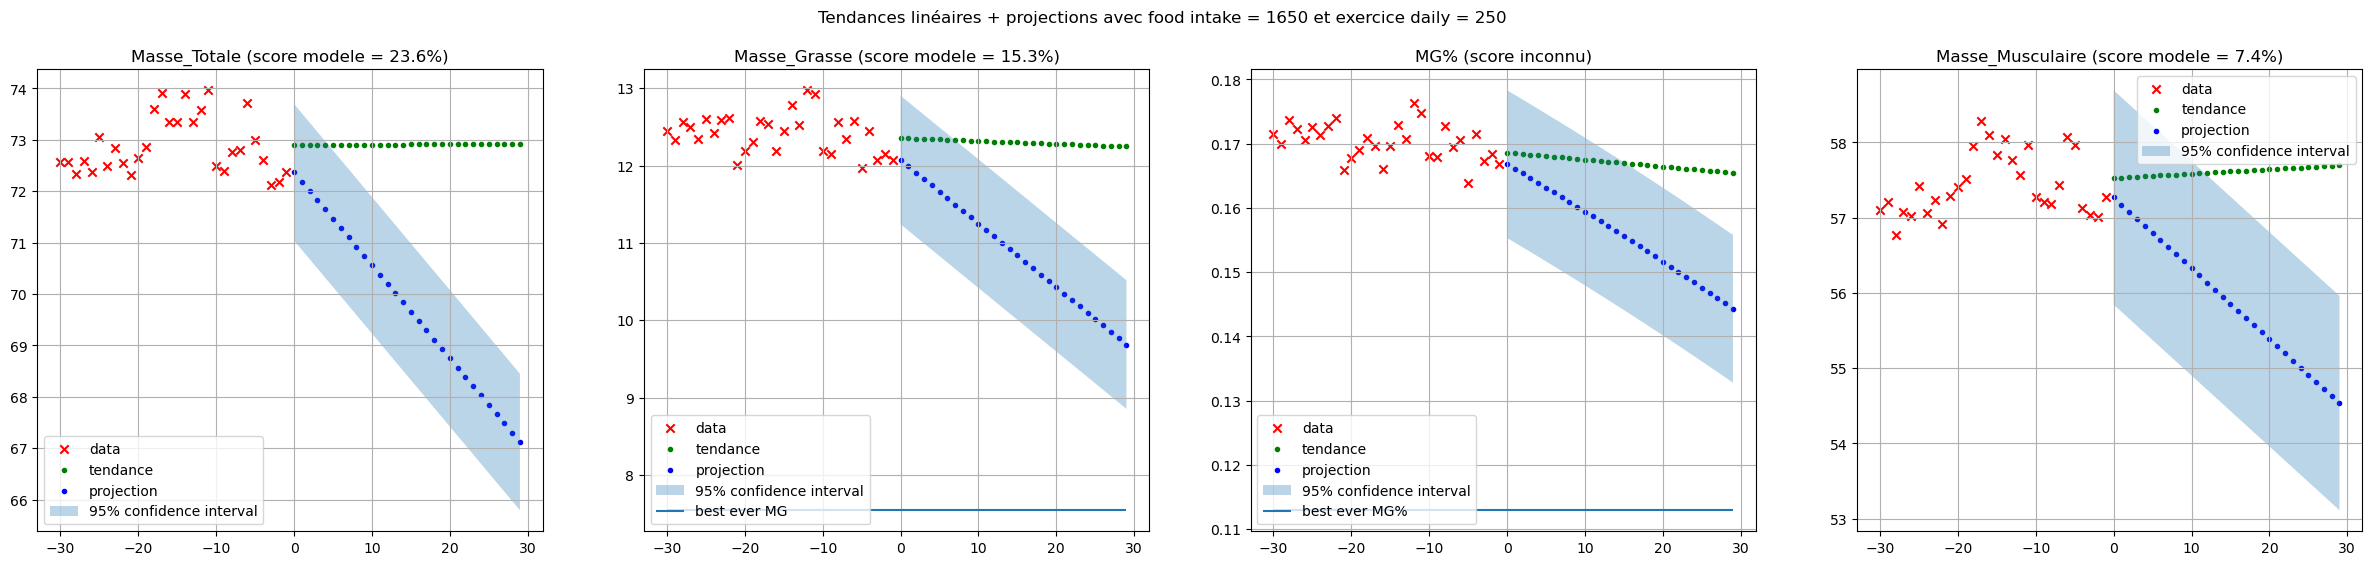

In [24]:
# Indicateurs Masse Totale, Masse Grasse, MG%, Masse Musculaire

X_past = np.array( [i for i in range(-horizon_past,0)] )
X_futur = np.array( [i for i in range(horizon_futur)] )
X = np.array([i for i in range(-horizon_past, horizon_futur)])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30,6))

for i, name in enumerate(data_columns):
    
    # tendances
    brr = linear_model.BayesianRidge()
    # brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    data_past = df_all[name][-horizon_past:].to_numpy()
    brr.fit( X_past.reshape(-1,1), data_past )
    
    data_futur = brr.predict(X_futur.reshape(-1,1))
    
    std = np.sqrt(1/brr.alpha_)
   
    axs[i].scatter(X_past, data_past, marker='x', color='red', label='data')
    axs[i].scatter(X_futur, data_futur, marker='.', color='green', label='tendance')
    if name=='MG%':
        titre = name + ' (score inconnu)'
    else:
        titre = name + ' (score modele = ' + f'{scores[name]*100:.1f}%)'
    axs[i].set_title(titre)
    axs[i].grid(True)
    
    # predictions avec hypothèses food intake et exercices
    if name=='MG%':
        y_pred_mt = np.array([ df_all['Masse_Totale'][-1] + X_futur * daily_delta['Masse_Totale'] ]).reshape(-1,1)
        y_pred_mg = np.array([ df_all['Masse_Grasse'][-1] + X_futur * daily_delta['Masse_Grasse'] ]).reshape(-1,1)
        y_pred = np.array([ y_pred_mg[j] / y_pred_mt[j] for j in list(X_futur)]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = np.array(noises['Masse_Grasse'] / df_all['Masse_Totale'][-1])  # estime une std sur MG%
    else:
        last_y = data_past[-1]
        dd = daily_delta[name]
        y_pred = np.array([ last_y + X_futur * dd ]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = noises[name]
    
    y_min = np.squeeze(y_pred - 1.96 * y_std)
    y_max = np.squeeze(y_pred + 1.96 * y_std)
    axs[i].fill_between(
        X_futur,
        y_min,
        y_max,
        alpha=0.3,
        label=r"95% confidence interval",
    )
    
    if name=='MG%':
        axs[i].hlines(best_ever_mgp, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG%')
    if name=='Masse_Grasse':
        axs[i].hlines(best_ever_mg, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG')
        
    axs[i].legend()
    
fig.suptitle(f'Tendances linéaires + projections avec food intake = {food_intake:.0f} et exercice daily = {exos_avg:.0f}')

plt.show()

In [25]:
MAX_CAL = 1650.0
PERIODE = 45
n_jours = 15
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 30 derniers jours = 1756 kcals/jour
Target quotidienne sur les 15 prochains jours pour tenir 1650 kcals quotidiennes = 1438 kcals/jour


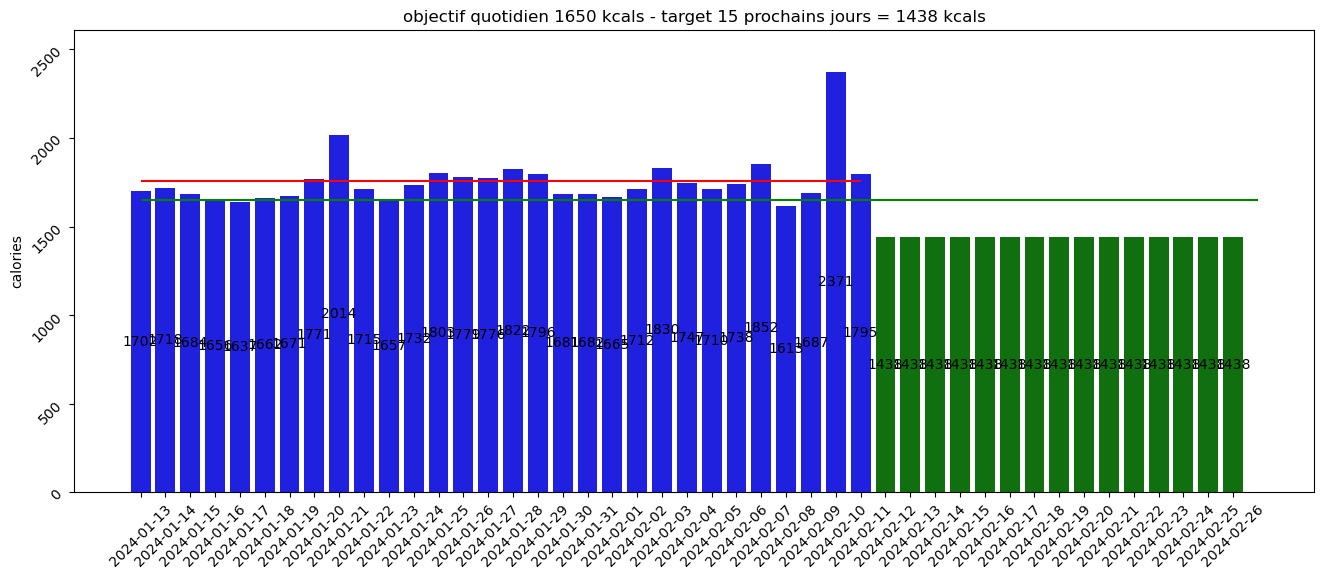

In [26]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

# Graphes

In [27]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [28]:
def plot_general(longueur=15,
                 year=2023,
                 month=11,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

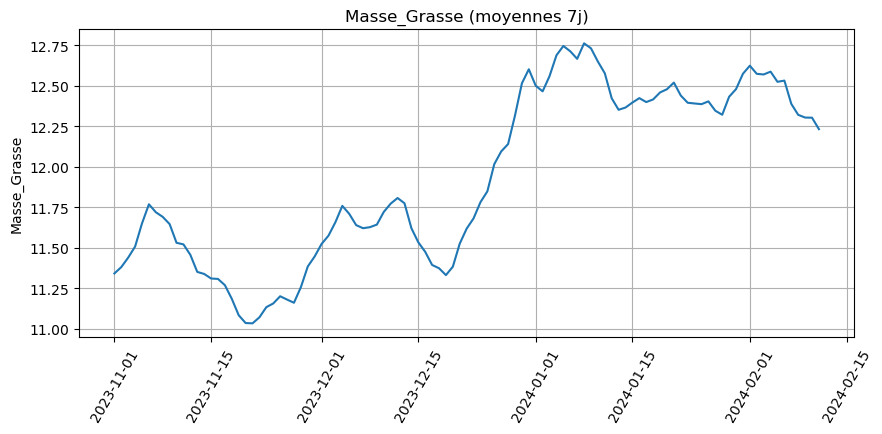

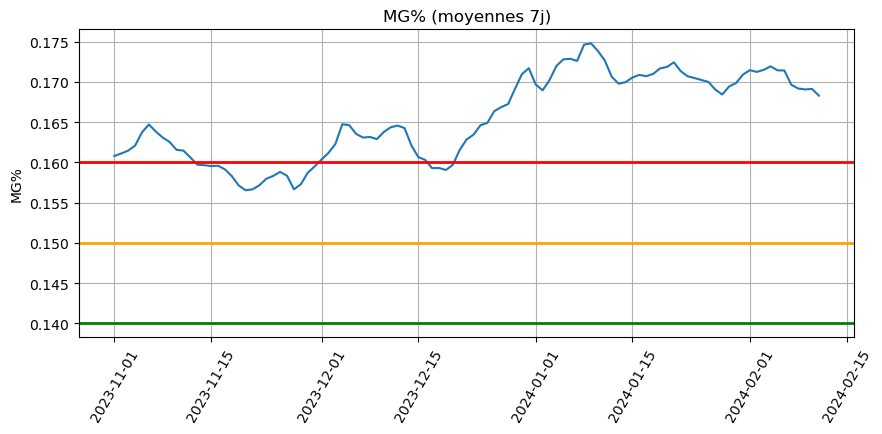

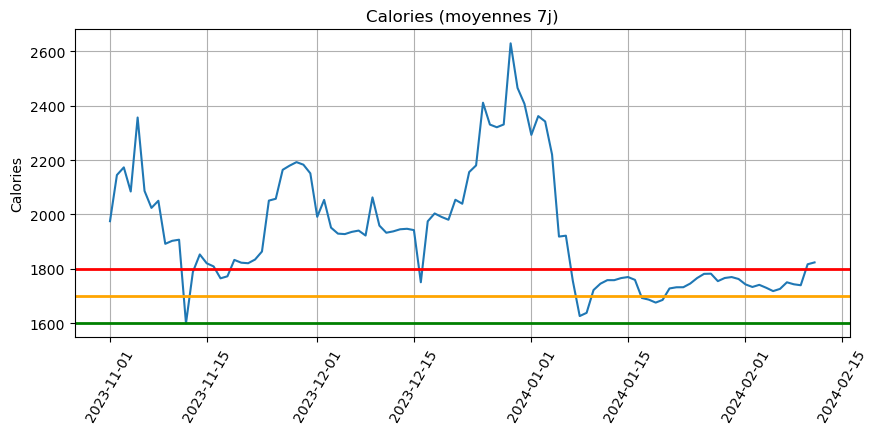

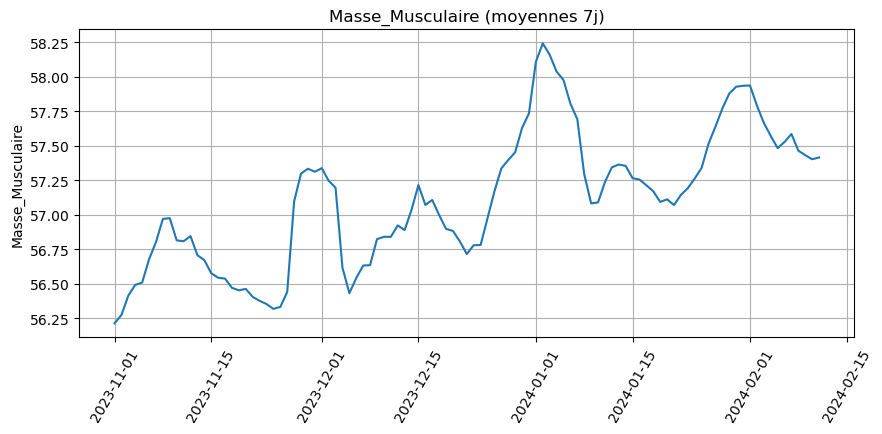

In [29]:
plot_general(longueur=7)

In [30]:
# vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

# ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

In [31]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [32]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [33]:
def plot_general3(longueur=15,
                 year=2023,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [34]:
# ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [35]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [36]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [37]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [38]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [39]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [40]:
# ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))